In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.varmax import VARMAX
import warnings
warnings.filterwarnings("ignore")


In [2]:
import kagglehub, os
path = kagglehub.dataset_download("vijayvvenkitesh/microsoft-stock-time-series-analysis")
df = pd.read_csv(os.path.join(path, "Microsoft_Stock.csv"))




In [3]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
df.set_index("Date", inplace=True)
data = df[["Open", "High", "Low", "Close"]]

In [4]:
# =====================================================
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled, columns=data.columns, index=data.index)

In [5]:
test_obs = 28
train = scaled_df[:-test_obs]
test = scaled_df[-test_obs:]


In [6]:
p_values = [1, 2]    # limit to 1 or 2 lags
q_values = [0, 1]    # limit MA terms to 0 or 1

best_aic = float("inf")
best_order = None
best_model = None

print("🔍 Selecting best (p,q) quickly ...\n")

🔍 Selecting best (p,q) quickly ...



In [7]:

for p, q in itertools.product(p_values, q_values):
    try:
        model = VARMAX(train, order=(p, q))
        result = model.fit(disp=False, maxiter=50)
        print(f"(p,q)=({p},{q}) | AIC={result.aic:.3f}")
        if result.aic < best_aic:
            best_aic = result.aic
            best_order = (p, q)
            best_model = result
    except:
        continue

print(f"\n✅ Best order found: (p,q)={best_order} | AIC={best_aic:.3f}")


(p,q)=(1,0) | AIC=-19521.313
(p,q)=(1,1) | AIC=-11379.229
(p,q)=(2,0) | AIC=-19556.387
(p,q)=(2,1) | AIC=-19886.093

✅ Best order found: (p,q)=(2, 1) | AIC=-19886.093


In [8]:
forecast = best_model.forecast(steps=test_obs)
forecast.index = test.index

In [9]:
forecast_inv = pd.DataFrame(
    scaler.inverse_transform(forecast),
    columns=forecast.columns,
    index=forecast.index
)
test_inv = pd.DataFrame(
    scaler.inverse_transform(test),
    columns=test.columns,
    index=test.index
)

In [10]:
# =====================================================
perf = {}
for col in data.columns:
    rmse = mean_squared_error(test_inv[col], forecast_inv[col], squared=False)
    mape = mean_absolute_percentage_error(test_inv[col], forecast_inv[col])
    perf[col] = {"RMSE": rmse, "MAPE": mape}

perf_df = pd.DataFrame(perf).T
print("\n📊 Performance Summary:")
print(perf_df)


📊 Performance Summary:
             RMSE      MAPE
Open   122.386652  0.523787
High   123.210894  0.521557
Low    119.461120  0.516284
Close   81.797091  0.340268


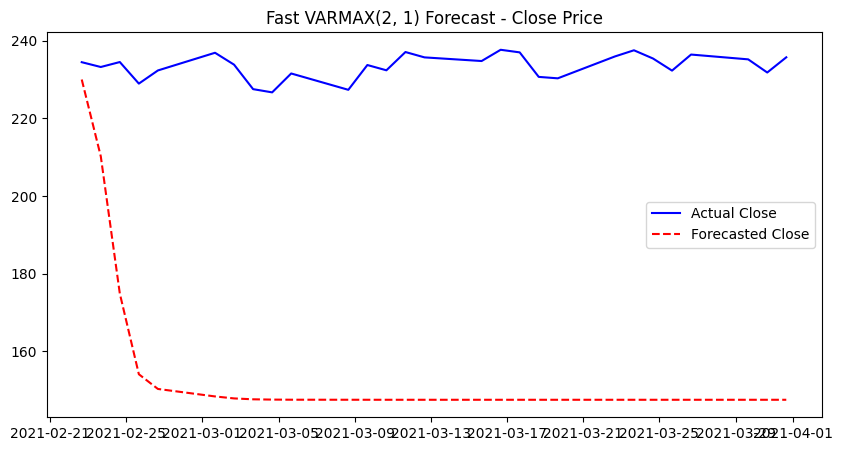

In [11]:
plt.figure(figsize=(10,5))
plt.plot(test_inv["Close"], label="Actual Close", color="blue")
plt.plot(forecast_inv["Close"], label="Forecasted Close", color="red", linestyle="--")
plt.title(f"Fast VARMAX{best_order} Forecast - Close Price")
plt.legend()
plt.show()